In [1]:
import numpy as np
import pandas as pd
import json
import os

In [2]:
data = []
with open('/kaggle/input/hubmap-hacking-the-human-vasculature/polygons.jsonl') as file:
    for lines in file:
        line = json.loads(lines)
        data.append(line)
        
data_js = pd.DataFrame(data)
data_js.head()

,id,annotations
0,0006ff2aa7cd,"[{'type': 'glomerulus', 'coordinates': [[[167,..."
1,00168d1b7522,"[{'type': 'glomerulus', 'coordinates': [[[511,..."
2,0033bbc76b6b,"[{'type': 'blood_vessel', 'coordinates': [[[16..."
3,003504460b3a,"[{'type': 'blood_vessel', 'coordinates': [[[40..."
4,004daf1cbe75,"[{'type': 'blood_vessel', 'coordinates': [[[14..."


# Non Segment Image

In [3]:
import os
from PIL import Image


def tifToImageTif(input_directory,output_directory,data_js):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Iterate through the files in the input directory
    for filename in data_js['id']:
        file_path = os.path.join(input_directory, f'{filename}.tif')
        #print(file_path)

        # Open the TIFF file using PIL
        image = Image.open(file_path)

        # Resize the image to 512x512
        resized_image = image.resize((512, 512))

        # Save the resized image
        output_path = os.path.join(output_directory, f'{filename}.tif')
        #output_path = os.path.join(output_directory, f'{filename}.tif')
        resized_image.save(output_path)

In [4]:
input_directory = '/kaggle/input/hubmap-hacking-the-human-vasculature/train'
output_directory = '/kaggle/working/data/non-segment'

tifToImageTif(input_directory,output_directory,data_js)

In [ ]:
#len(os.listdir('/kaggle/working/data/non-segment'))  #train image

# test folder

In [ ]:
list_file = os.listdir('test')

for file in list_file:
    file_path = os.path.join('/kaggle/input/hubmap-hacking-the-human-vasculature/test',file)
    
    image = Image.open(file_path)
    resize_image = image.resize((512,512))
    
    # Save the resized image
    if not os.path.exists('/kaggle/working/test'):
        os.makedirs('/kaggle/working/test')

    output_path = os.path.join('/kaggle/working/test', file)
    #output_path = os.path.join(output_directory, f'{filename}.tif')
    resize_image.save(output_path)

In [ ]:
#len(os.listdir('/kaggle/working/test'))

In [ ]:
#resize_image

# pointTo Image

In [6]:
import os


def pointToImage(type_seg,data_js):
    # Create the "Image" folder if it doesn't exist
    image_folder = f'/kaggle/working/data/segment/{type_seg}'
    os.makedirs(image_folder, exist_ok=True)



    for i in range(len(data_js)):
        mask = np.zeros((512,512))
        name_id = data_js['id'][i]
        for annot in data_js['annotations'][i]:
            cords = annot['coordinates']
            if annot['type'] == type_seg:
                for cd in cords:
                    rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                    mask[rr, cc] = 1
        mask_image = Image.fromarray(mask.astype(np.uint8) * 255)
        mask_image

        # Define the file path for saving the mask image
        mask_image_path = os.path.join(image_folder, f"{name_id}.png")

        # Save the mask image
        mask_image.save(mask_image_path)

In [7]:
pointToImage(type_seg = 'blood_vessel', data_js = data_js)

In [8]:
pointToImage(type_seg = 'glomerulus', data_js = data_js)

In [ ]:
#os.listdir('/kaggle/working/data/segment')

In [ ]:

# def print_directory_tree(root_directory):
#     for root, dirs, _ in os.walk(root_directory):
#         level = root.replace(root_directory, '').count(os.sep)
#         indent = ' ' * 4 * (level)
#         print(f"{indent}{os.path.basename(root)}/")

# # Specify the root directory
# root_directory = '/kaggle/working'

# # Call the function to print the directory tree
# print_directory_tree(root_directory)

# model

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

2023-06-03 07:16:36.135135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 07:16:36.577217: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-03 07:16:36.577244: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-03 07:16:38.128943: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [7]:
from PIL import Image
import numpy as np

#image = Image.open('/kaggle/working/data/non-segment/0006ff2aa7cd.tif')

In [ ]:
#image

In [12]:
import os
from PIL import Image

non_segment_dir = '/kaggle/working/data/non-segment'
segment_dir = '/kaggle/working/data/segment/blood_vessel'
image_size = (256, 256)

# Get a list of image filenames in the non-segmented folder
non_segment_files = os.listdir(non_segment_dir)

train_images = []
train_labels = []

# Load the images and labels
for filename in non_segment_files:
    image_path = os.path.join(non_segment_dir, filename)
    label_filename = f"{filename.split('.')[0]}.png"
    label_path = os.path.join(segment_dir, label_filename)

    # Load the non-segmented image
    image = Image.open(image_path)
    image = image.resize(image_size)
    image = np.array(image)/255.0
    train_images.append(image)

    # Load the corresponding segmented label
    label = Image.open(label_path)
    label = label.resize(image_size)
    label = np.array(label)/255.0
    train_labels.append(label)

# Perform any further processing or conversion if needed

# Convert the lists to NumPy arrays or use them directly for training
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Print the shapes of the loaded images and labels
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)

Train Images Shape: (1633, 256, 256, 3)
Train Labels Shape: (1633, 256, 256)


In [13]:
train_labels = train_labels.reshape(len(train_labels),256,256,1)

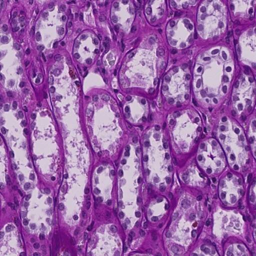

In [14]:
Image.fromarray((train_images[1].reshape(256,256,3)*255.0).astype(np.uint8))

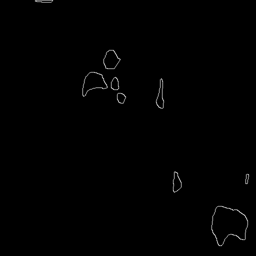

In [15]:
Image.fromarray((train_labels[1].reshape(256,256)*255.0).astype(np.uint8))

In [16]:
import tensorflow as tf

def train(model, train_images, train_labels, num_epochs, batch_size):
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        total_loss = 0

        # Iterate over batches of images and labels
        for step in range(0, len(train_images), batch_size):
            batch_images = train_images[step:step+batch_size]
            batch_labels = train_labels[step:step+batch_size]

            # Forward pass
            with tf.GradientTape() as tape:
                predictions = model(batch_images)
                loss_value = loss_fn(batch_labels, predictions)
                total_loss += loss_value

            # Backward pass and optimization
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Compute average loss for the epoch
        average_loss = total_loss / (len(train_images) // batch_size)
        print(f"Epoch {epoch+1} loss: {average_loss}")

In [17]:
# Example usage
model = unet_model(input_shape=(256, 256, 3))  # Create the U-Net model


num_epochs = 30
batch_size = 20

train(model, train_images, train_labels, num_epochs, batch_size)

Epoch 1/30
Epoch 1 loss: 0.06014742702245712
Epoch 2/30
Epoch 2 loss: 0.03309968113899231
Epoch 3/30
Epoch 3 loss: 0.03247387334704399
Epoch 4/30
Epoch 4 loss: 0.03195463865995407
Epoch 5/30
Epoch 5 loss: 0.03137844428420067
Epoch 6/30
Epoch 6 loss: 0.030766166746616364
Epoch 7/30
Epoch 7 loss: 0.030267126858234406
Epoch 8/30
Epoch 8 loss: 0.029082896187901497
Epoch 9/30
Epoch 9 loss: 0.02803974412381649
Epoch 10/30
Epoch 10 loss: 0.026974577456712723
Epoch 11/30
Epoch 11 loss: 0.025570834055542946
Epoch 12/30
Epoch 12 loss: 0.02464994601905346
Epoch 13/30
Epoch 13 loss: 0.02411825768649578
Epoch 14/30
Epoch 14 loss: 0.02349894680082798
Epoch 15/30
Epoch 15 loss: 0.023043831810355186
Epoch 16/30
Epoch 16 loss: 0.022882254794239998
Epoch 17/30
Epoch 17 loss: 0.022754039615392685
Epoch 18/30
Epoch 18 loss: 0.02222737856209278
Epoch 19/30
Epoch 19 loss: 0.021801140159368515
Epoch 20/30
Epoch 20 loss: 0.02160187065601349
Epoch 21/30
Epoch 21 loss: 0.021407272666692734
Epoch 22/30
Epoch 22 

In [ ]:
#train(model, train_images, train_labels, num_epochs, batch_size)

In [5]:
model = tf.keras.models.load_model('model(1).h5')

2023-06-03 07:18:06.481958: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-03 07:18:06.481993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (limsim-inspiron5584): /proc/driver/nvidia/version does not exist
2023-06-03 07:18:06.482766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


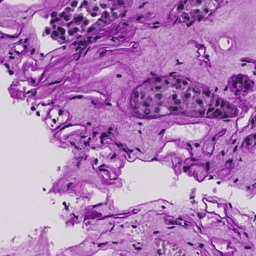

In [8]:
image = Image.open('test/72e40acccadf.tif')
image = image.resize((256,256))
image

In [9]:
image = np.array(image).reshape(1,256,256,3)/255.0
y_pred = model.predict(image)

1/1 [==============================] - 1s 872ms/step


In [10]:
y_pred = y_pred.reshape(256, 256)

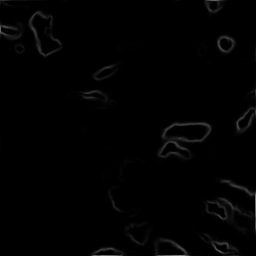

In [11]:
Image.fromarray((y_pred*255.0).astype(np.uint8))

In [ ]:
#y_pred

# submission

## part 1

In [ ]:
! pip install pycocotools

In [14]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib

In [15]:
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

In [16]:
test_path = "test"
sample_submission = pd.read_csv('sample_submission.csv')


In [ ]:


import base64
import numpy as np
import typing as t
import zlib

import numpy as np
from itertools import groupby

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    encoded_mask  = binary_mask_to_rle(img)
    encoded_mask = encoded_mask["counts"]
    encoded_mask  = [ str(x) for x in encoded_mask] 
    encoded_mask = " ".join(encoded_mask)
    binary_str = zlib.compress(encoded_mask.encode(), zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode() 



In [23]:
#! pip install pycocotools

In [24]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import zlib

def encode_binary_mask(mask: np.ndarray) -> str:
    """Converts a binary mask into OID challenge encoding format.
    
    Args:
        mask (np.ndarray): Binary mask to be encoded.
    
    Returns:
        str: Encoded mask in the format expected by the OID challenge.
    """

    if mask.dtype != np.bool:
        raise ValueError("encode_binary_mask expects a binary mask, received dtype == %s" % mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError("encode_binary_mask expects a 2d mask, received shape == %s" % mask.shape)

    # Convert input mask to the expected COCO API input format
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # Compress and base64 encode the mask
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str).decode()

    return base64_str


In [37]:
encoded_string = []  # Initialize an empty list to store the encoded masks
name_id = []
size = []

for file in os.listdir('/kaggle/working/test'):
    name_id.append(file.split('.')[0])
    # Load the non-segmented image
    image = Image.open('/kaggle/working/test/' + file)
    image = image.resize(image_size)
    image = np.array(image) / 255.0
    image = image.reshape(1, 256, 256, 3)
    
    size.append(256)
    y_pred = model.predict(image)
    y_pred = y_pred.reshape(256, 256)
    
    # Threshold the predicted mask
    threshold = 0.4  # Adjust this threshold as needed
    y_pred_binary = (y_pred >= threshold).astype(np.bool)
    
    # Encode the predicted mask
    encoded_mask = encode_binary_mask(y_pred_binary)

    # Append the encoded mask to the list
    encoded_string.append(f'0 1.0 {encoded_mask}')

1/1 [==============================] - 0s 23ms/step


/tmp/ipykernel_28/686614692.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred_binary = (y_pred >= threshold).astype(np.bool)
/tmp/ipykernel_28/2256478135.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if mask.dtype != np.bool:


In [ ]:
# encoded_string = []
# name_id = []
# size = []
# for file in os.listdir('/kaggle/working/test'):
#     name_id.append(file.split('.')[0])
#     # Load the non-segmented image
#     image = Image.open('/kaggle/working/test/' + file)
#     image = image.resize(image_size)
#     image = np.array(image)/255.0
#     image = image.reshape(1,256,256,3)
    
#     size.append(256)
#     y_pred = model.predict(image)
#     y_pred = y_pred.reshape(256,256)
    
#     encoded_string.append(f'0 1.0 {rle_encode(y_pred)}')

In [33]:
sub = pd.read_csv('/kaggle/input/hubmap-hacking-the-human-vasculature/sample_submission.csv')
sub

,id,height,width,prediction_string
0,72e40acccadf,512,512,0 1.0 eNoLTDAwyrM3yI/PMwcAE94DZA==


In [38]:
sub['id'] = name_id
sub['height'] = size
sub['width'] = size
sub['prediction_string'] = encoded_string

In [39]:
sub.to_csv("submission.csv", index= False)
sub.head()

,id,height,width,prediction_string
0,72e40acccadf,256,256,0 1.0 eNrLj880MMw3N4CAgAR7g4AAR4MABwNcICQu0cAu...


In [40]:
encoded_string

['0 1.0 eNrLj880MMw3N4CAgAR7g4AAR4MABwNcICQu0cAuOjrOHwCeEA3j']